In [1]:
import json  
import pandas as pd 
from pandas import json_normalize 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
review_df = pd.read_csv('C:\\Users\\ineso\\FEUP-3ano\\gulbenkian-ai\\DatasetSamples\\review_sample.csv')
user_df = pd.read_csv('C:\\Users\\ineso\\FEUP-3ano\\gulbenkian-ai\\DatasetSamples\\user_sample.csv')
business_df = pd.read_csv('C:\\Users\\ineso\\FEUP-3ano\\gulbenkian-ai\\DatasetSamples\\business_sample.csv')

In [3]:
business_df['categories'] = business_df['categories'].fillna("")

In [4]:
G = nx.Graph()

categories = []
businesses = []
b_to_c = []

for index, row in business_df.iterrows():
    G.add_node(row['business_id'], name=row['name'], type="business")
    businesses.append(row['business_id'])
    
    cat = row['categories'].split(", ")
    for c in cat:
        if c not in categories:
            G.add_node(c, type="category")
            categories.append(c)
        G.add_edge(row['business_id'], c)
        b_to_c.append((row['business_id'], c))

In [5]:
users = []
friend = []

for index, row in user_df.iterrows():
    G.add_node(row['user_id'], name=row['name'], type="user")
    users.append(row['user_id'])

for index, row in user_df.iterrows():
    friends = row['friends'].split(", ")
    for f in friends:
        if f in users:
            G.add_edge(row['user_id'], f)
            friend.append((row['user_id'], f))

In [6]:
reviews = []

for index, row in review_df.iterrows():
    if row['user_id'] in users and row['business_id'] in businesses:
        G.add_edge(row['user_id'], row['business_id'], rating=row['stars'])
        reviews.append((row['user_id'], row['business_id']))

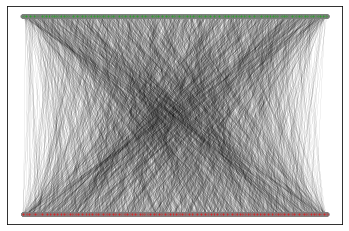

In [28]:
pos = nx.bipartite_layout(G, users, align='horizontal')#, seed=3113794652)
options = {"edgecolors": "tab:gray", "node_size": 10, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=businesses, node_color="tab:red", **options)
#nx.draw_networkx_nodes(G, pos, nodelist=categories, node_color="tab:blue", **options)
nx.draw_networkx_nodes(G, pos, nodelist=users, node_color="tab:green", **options)

#nx.draw_networkx_edges(G, pos, edgelist=friend, width=0.1, alpha=0.5, arrows=False)
#nx.draw_networkx_edges(G, pos, edgelist=b_to_c, width=0.1, alpha=0.5, arrows=False)
nx.draw_networkx_edges(G, pos, edgelist=reviews, width=0.1, alpha=0.5, arrows=False)

In [7]:
business_pairs = []
for b1 in businesses:
    for b2 in businesses:
        if b1 != b2:
            business_pairs.append((b1, b2))

preds = nx.jaccard_coefficient(G, business_pairs)
for u, v, p in preds:
    G.add_edge(u, v, similarity=p)

KeyboardInterrupt: 

In [ ]:
count = 0
for u, v, p in preds:
    if count < 10:
        print(f"({u}, {v}) -> {p:.8f}")

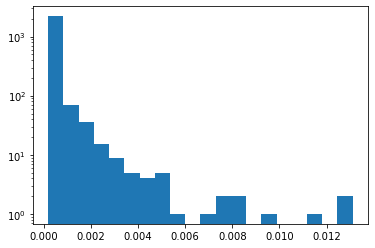

In [8]:
# Compute the degree centralities: dcs
dcs = nx.degree_centrality(G)

# Get the degree centralities for user_nodes: user_dcs
user_dcs = [dcs[n] for n in users]

# Plot the degree distribution of users_dcs
plt.yscale('log')
plt.hist(user_dcs, bins=20)
plt.show()

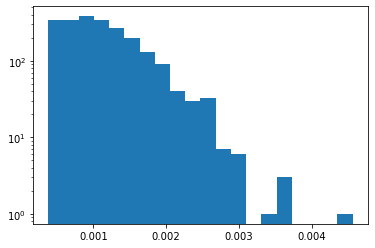

In [9]:
business_dcs = [dcs[n] for n in businesses]

# Plot the degree distribution of users_dcs
plt.yscale('log')
plt.hist(business_dcs, bins=20)
plt.show()

In [10]:
def shared_partition_nodes(G, node1, node2):
    # Check that the nodes belong to the same partition
    assert G.nodes[node1]['type'] == G.nodes[node2]['type']

    # Get neighbors of node 1: nbrs1
    nbrs1 = G.neighbors(node1)
    # Get neighbors of node 2: nbrs2
    nbrs2 = G.neighbors(node2)

    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)
    return overlap

In [24]:
def user_similarity(G, user1, user2):
    # Check that the nodes belong to the 'users' partition
    assert G.nodes[user1]['type'] == 'user'
    assert G.nodes[user2]['type'] == 'user'

    # Get the set of nodes shared between the two users
    shared_nodes = shared_partition_nodes(G, user1, user2)

    # Return the fraction of nodes in the projects partition
    return len(shared_nodes) / len(businesses)

In [25]:
user_similarities = []

for u1 in users:
    for u2 in users:
        if u1 != u2:
            user_similarities.append(user_similarity(G, u1, u2))

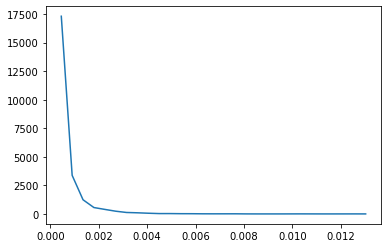

In [31]:
x = list(dict.fromkeys(user_similarities))
x.remove(0)
x.sort()
y = []
for n in x:
    y.append(user_similarities.count(n))

fig, ax = plt.subplots()
ax.plot(x, y)

In [37]:
from collections import defaultdict

def most_similar_users(G, user):
    # Data checks
    assert G.nodes[user]['type'] == 'user'

    # Get other nodes from user partition
    user_nodes = set(users)
    user_nodes.remove(user)

    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = max(similarities.keys())
    if(max_similarity == 0): return []
    # Return list of users that share maximal similarity
    return similarities[max_similarity]

In [41]:
def recommend_businesses(G, from_user, to_user):
    # Get the set of repositories that from_user has contributed to
    from_businesses = set(G.neighbors(from_user))
    # Get the set of repositories that to_user has contributed to
    to_businesses = set(G.neighbors(to_user))

    # Identify repositories that the from_user is connected to that the to_user is not connected to
    return from_businesses.difference(to_businesses)

In [50]:
# Print the repositories to be recommended
for u1 in users:
    l = users.copy()
    l.remove(u1)
    for u2 in l:
        res = recommend_businesses(G, test_users[0], test_users[0])
        if len(res)>0:
            print(res)
            break